In [1]:
import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [2]:
df_length = pd.read_csv('../data/clean_data_length.csv')
df_length = df_length[(df_length['global_length']>0) | (df_length['user_mask_length']>0)]
df_length.columns

Index(['exc_num', 'uid', 'length', 'day', 'exc_times', 'global_length',
       'user_mask_length'],
      dtype='object')

# 1. Trends and Variation in Training  Time
use Pearson Correlation to check if there is correlation between training times and training time

- pearson_value: The Pearson correlation coefficient measures the linear relationship between two datasets 
- p_value: The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets.

In [3]:
data = df_length.sort_values(['day', 'exc_times'])
data = df_length.set_index(['uid', 'exc_num'])

grouped = data.groupby(by=data.index)
df_pearson = pd.DataFrame(columns=['uid', 'exc_num', 'pearson_values', 'p_values'])

for index, group in grouped:
    if len(group)>3:
        exc_index = [i for i in xrange(len(group))]
        pearson_value, p_value = pearsonr(exc_index, group['length'].tolist())
        uid, exc_num = index
        curr = pd.DataFrame([[uid, exc_num, pearson_value, p_value]], columns=['uid', 'exc_num', 'pearson_values', 'p_values'])
        df_pearson = pd.concat([df_pearson, curr])
        
print('average value of pearson correlation over all single exercise: ' + str(df_pearson['pearson_values'].mean()))
print('Probability, that the training time and training times has no correlation: ' + str(df_pearson['p_values'].mean()))

average value of pearson correlation over all single exercise: -0.294521346406
Probability, that the training time and training times has no correlation: 0.424819436296


### Draw a whisker box

In [4]:
tmp = df_pearson.set_index(['uid', 'exc_num'])
tmp = tmp.stack().reset_index()
tmp.columns = ['uid', 'exc_num', 'level', 'value']
tmp.head()

,uid,exc_num,level,value
0,1,1.2,pearson_values,-0.887075
1,1,1.2,p_values,0.044774
2,1,1.3,pearson_values,-0.390526
3,1,1.3,p_values,0.443991
4,1,1.4,pearson_values,-0.842580


whisker box on each pearson

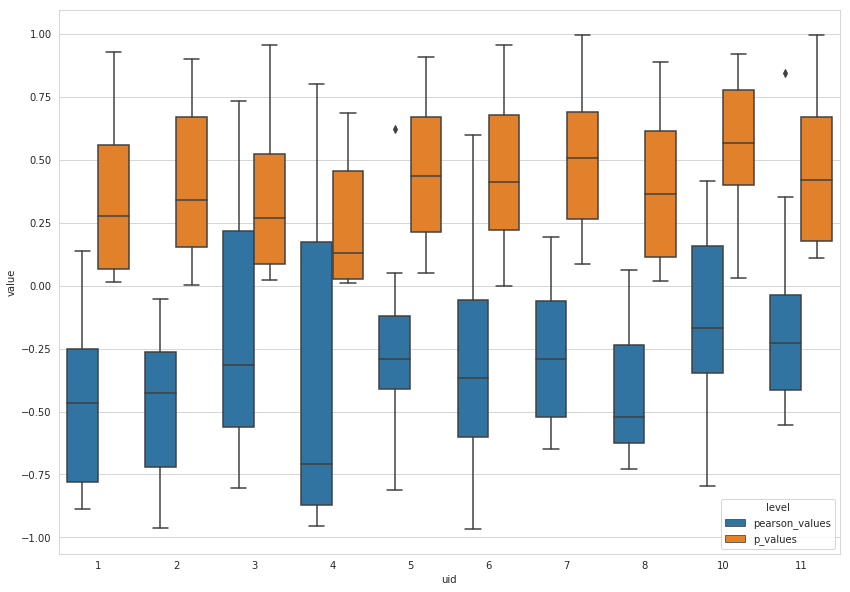

In [5]:
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.boxplot(x='uid', y="value", hue='level', data=tmp)

### Observe something more in detail

the most expected and unexpected curve

In [6]:
expected = df_pearson[df_pearson['pearson_values'] == df_pearson['pearson_values'].min()]
unexpected = df_pearson[df_pearson['pearson_values'] == df_pearson['pearson_values'].max()]
print(expected)
print(unexpected)

  uid  exc_num  pearson_values  p_values
0   6      2.3       -0.967006  0.000021
  uid  exc_num  pearson_values  p_values
0  11      1.3        0.844146  0.155854


Text(0.5,1,'the most expected curve (uid: 6 exc_num: 2.3)')

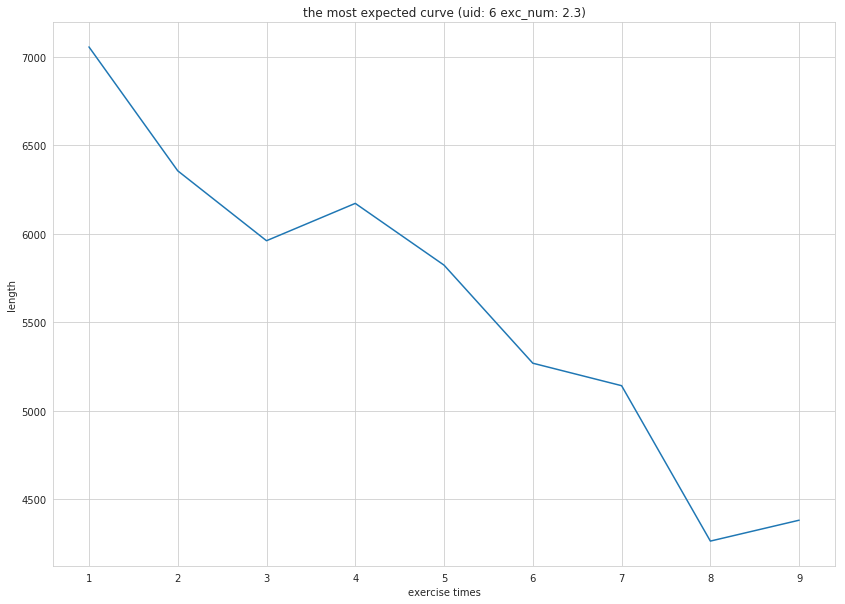

In [7]:
uid = expected['uid'].tolist()[0]
exc_num = expected['exc_num'].tolist()[0]
tmp = data.loc[(uid, exc_num), :].reset_index().reset_index()
tmp['index'] = tmp['index']+1

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp['index'], y="length", data=tmp)
ax.set(xlabel='exercise times')
ax.set_title('the most expected curve (uid: '+str(uid)+' exc_num: '+str(exc_num)+')')

Text(0.5,1,'the most unexpected curve (uid: 11 exc_num: 2.3)')

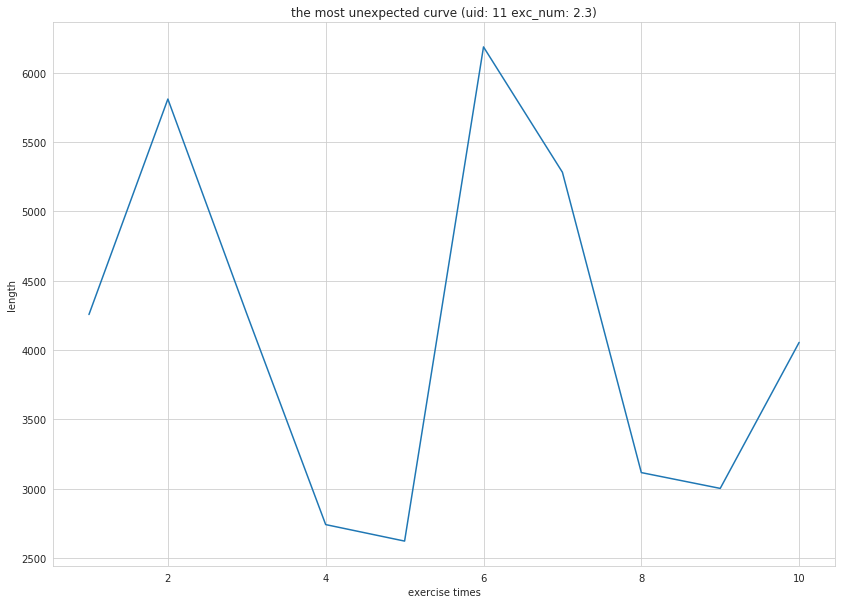

In [8]:
uid = unexpected['uid'].tolist()[0]
exc_num = expected['exc_num'].tolist()[0]
tmp = data.loc[(uid, exc_num), :].reset_index().reset_index()
tmp['index'] = tmp['index']+1

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp['index'], y="length", data=tmp)
ax.set(xlabel='exercise times')
ax.set_title('the most unexpected curve (uid: '+str(uid)+' exc_num: '+str(exc_num)+')')

### Conclusion:
with the exercises the most people in most exercise item can shorten the finish time， but the exercises that be separated in two day (repitition on next day or on the last training day), in the first repitition on the second day one maybe need more time than the in the last repitition on the first day.

two possible reasons:
- need time to adapt to the platform
- the time depends on the user's health status on that day

# 2. Trends and Variation in Evaluation Value

### Evaluation method

In [9]:
%reset -f

import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr


def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df
    
def evaluation_method1(df, factor=2):
    df['score'] = df['front']*df['velocity']/factor
    df = df[['day', 'exc_num', 'exc_times', 'score', 'uid']]
    df = df.groupby(['day', 'exc_num', 'exc_times', 'uid']).sum()
    df = df.reset_index()
    return df

load dataset 

In [10]:
all_data = pd.read_csv('../data/all_data1.csv')
all_data = calc_force(all_data)
all_data = calc_velocity(all_data)
all_data = evaluation_method1(all_data)

df_length = pd.read_csv('../data/clean_data_length.csv')
df_score1 = pd.read_csv('../data/clean_data_score1.csv')

df_length = df_length.set_index(['uid', 'day', 'exc_num', 'exc_times'])
df_score1 = df_score1.set_index(['uid', 'day', 'exc_num', 'exc_times'])


cleaned_index = pd.concat([df_length, df_score1], axis=1)
cleaned_index.columns

Index(['length', 'global_length', 'user_mask_length', 'score', 'global_score1',
       'user_mask_score1'],
      dtype='object')

transform data

In [11]:
cleaned_index = cleaned_index[(cleaned_index['global_length']>0) | (cleaned_index['user_mask_length']>0)]
cleaned_index = cleaned_index[(cleaned_index['global_score1']>0) & (cleaned_index['user_mask_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['global_score1']>0)]
# cleaned_index = cleaned_index[(cleaned_index['user_mask_score1']>0)]

cleaned_index = cleaned_index.reset_index()
cleaned_index = cleaned_index.set_index(['uid', 'day', 'exc_num', 'exc_times', 'score'])

all_data = all_data.set_index(['uid', 'day', 'exc_num', 'exc_times', 'score'])
cleaned_data = pd.concat([cleaned_index, all_data], axis=1)
cleaned_data = cleaned_data.dropna()
cleaned_data = cleaned_data.reset_index()
cleaned_data.columns

Index(['uid', 'day', 'exc_num', 'exc_times', 'score', 'length',
       'global_length', 'user_mask_length', 'global_score1',
       'user_mask_score1'],
      dtype='object')

In [12]:
data = cleaned_data.sort_values(['day', 'exc_times'])
data = cleaned_data.set_index(['uid', 'exc_num'])


grouped = data.groupby(by=data.index)
df_pearson = pd.DataFrame(columns=['uid', 'exc_num', 'pearson_values', 'p_values'])

for index, group in grouped:
    if len(group)>3:
        exc_index = [i for i in xrange(len(group))]
        pearson_value, p_value = pearsonr(exc_index, group['score'].tolist())
        uid, exc_num = index
        curr = pd.DataFrame([[uid, exc_num, pearson_value, p_value]], columns=['uid', 'exc_num', 'pearson_values', 'p_values'])
        df_pearson = pd.concat([df_pearson, curr])
        
print('average value of pearson correlation over all single exercise: ' + str(df_pearson['pearson_values'].mean()))
print('Probability, that the training time and training times has no correlation: ' + str(df_pearson['p_values'].mean()))

average value of pearson correlation over all single exercise: -0.248230138516
Probability, that the training time and training times has no correlation: 0.415673053055


In [13]:
tmp = df_pearson.set_index(['uid', 'exc_num'])
tmp = tmp.stack().reset_index()
tmp.columns = ['uid', 'exc_num', 'level', 'value']
tmp.head()

,uid,exc_num,level,value
0,1,1.2,pearson_values,-0.242802
1,1,1.2,p_values,0.757198
2,1,1.3,pearson_values,-0.067732
3,1,1.3,p_values,0.898558
4,1,1.4,pearson_values,-0.215421


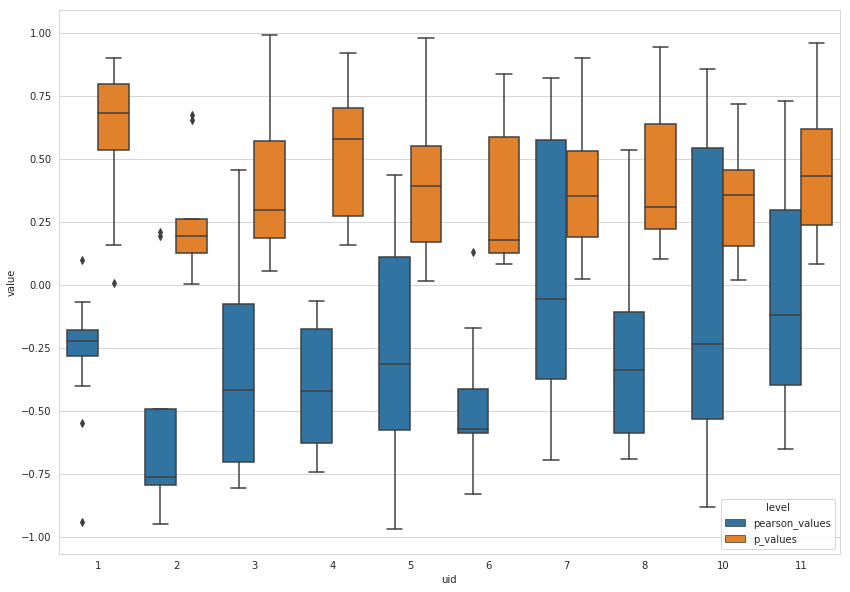

In [14]:
sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.boxplot(x='uid', y="value", hue='level', data=tmp)

In [15]:
expected = df_pearson[df_pearson['pearson_values'] == df_pearson['pearson_values'].min()]
unexpected = df_pearson[df_pearson['pearson_values'] == df_pearson['pearson_values'].max()]
print(expected)
print(unexpected)

  uid  exc_num  pearson_values  p_values
0   5      4.2       -0.969897  0.030103
  uid  exc_num  pearson_values  p_values
0  10      4.1        0.856024  0.143976


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Text(0.5,1,'the most expected curve (uid: 5 exc_num: 4.2)')

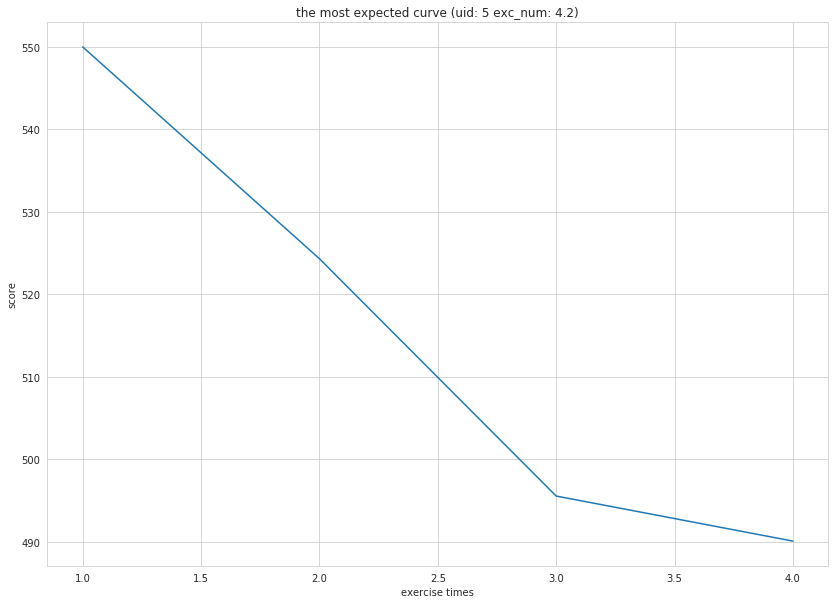

In [18]:
uid = expected['uid'].tolist()[0]
exc_num = expected['exc_num'].tolist()[0]
tmp = data.loc[(uid, exc_num), :].reset_index().reset_index()
tmp['index'] = tmp['index']+1

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp['index'], y="score", data=tmp)
ax.set(xlabel='exercise times')
ax.set_title('the most expected curve (uid: '+str(uid)+' exc_num: '+str(exc_num)+')')

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Text(0.5,1,'the most unexpected curve (uid: 10 exc_num: 4.2)')

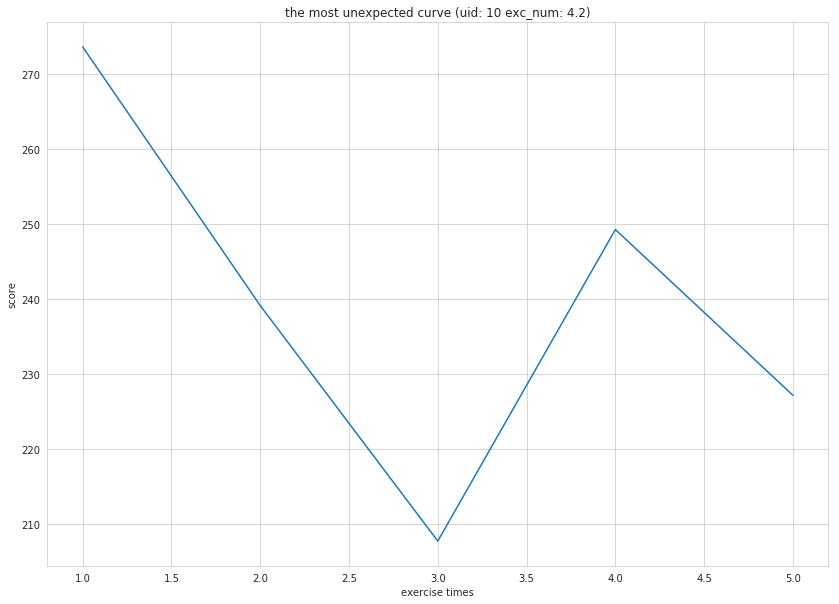

In [19]:
uid = unexpected['uid'].tolist()[0]
exc_num = expected['exc_num'].tolist()[0]
tmp = data.loc[(uid, exc_num), :].reset_index().reset_index()
tmp['index'] = tmp['index']+1

sns.set_style('whitegrid')
f, ax= plt.subplots(figsize = (14, 10))
ax = sns.lineplot(x=tmp['index'], y="score", data=tmp)
ax.set(xlabel='exercise times')
ax.set_title('the most unexpected curve (uid: '+str(uid)+' exc_num: '+str(exc_num)+')')